# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

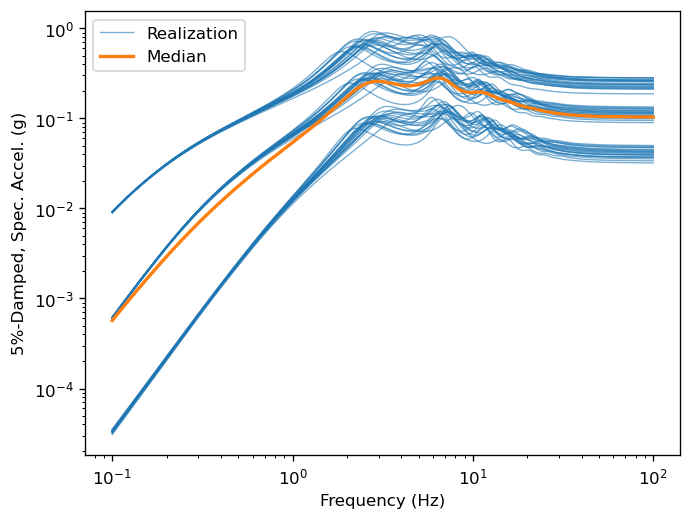

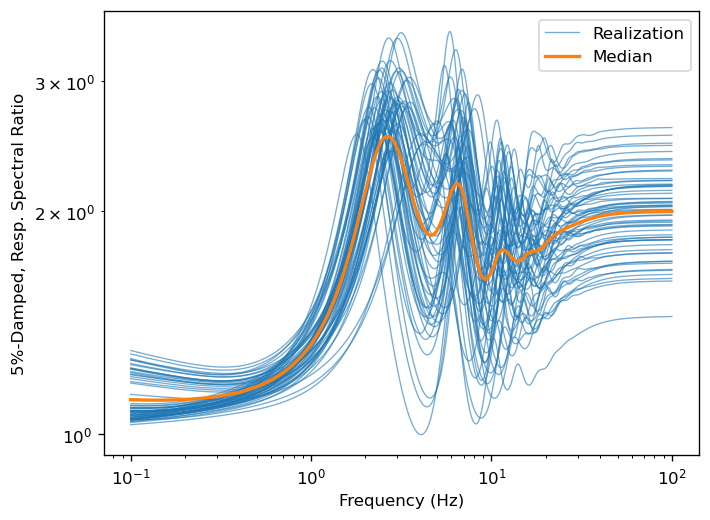

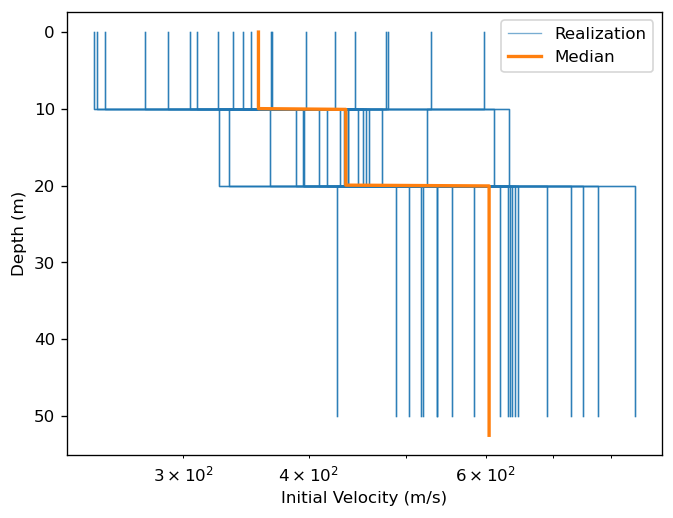

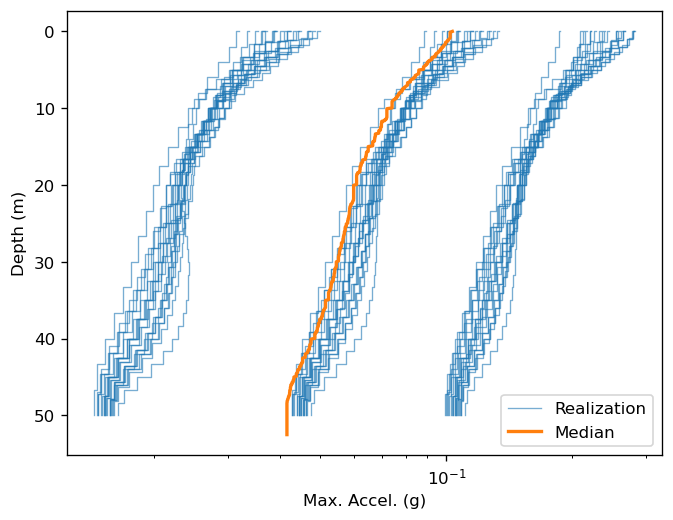

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.264424  1.085367  1.052020  1.130895  1.045807  1.029169   
0.101394    1.263338  1.085281  1.052418  1.130573  1.045793  1.029404   
0.102807    1.262257  1.085200  1.052820  1.130252  1.045782  1.029642   
0.104240    1.261178  1.085126  1.053227  1.129932  1.045775  1.029882   
0.105693    1.260104  1.085058  1.053639  1.129613  1.045773  1.030124   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.664439  1.609926  1.441268  2.215982  2.083473  2.012752   
95.932095   1.664512  1.610011  1.441367  2.215997  2.083481  2.012789   
97.269336   1.664583  1.610094  1.441463  2.216012  2.083488  2.012824   
98.625218   1.664653  1.610174  1.441556  2.216026  2.083494  2.012859   
100.000000  1.664720  1.610251  1.441646  2.216040  2.083501  2.012892   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.259456  1.091125  1.060352  1.210628  ...  1.043987  1.176868   
0.101394    1.258600  1.091042  1.060798  1.209883  ...  1.044327  1.176354   
0.102807    1.257747  1.090965  1.061249  1.209140  ...  1.044671  1.175843   
0.104240    1.256896  1.090893  1.061704  1.208400  ...  1.045018  1.175333   
0.105693    1.256049  1.090826  1.062163  1.207663  ...  1.045369  1.174826   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   2.597055  2.410604  2.173495  1.911319  ...  2.062833  2.204007   
95.932095   2.597163  2.410716  2.173653  1.911391  ...  2.062927  2.204071   
97.269336   2.597268  2.410824  2.173806  1.911461  ...  2.063018  2.204134   
98.625218   2.597369  2.410929  2.173954  1.911529  ...  2.063106  2.204195   
100.000000  2.597467  2.411031  2.174098  1.911595  ...  2.063192  2.204253   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.061732  1.039426  1.214250  1.074033  1.047922  1.187829   
0.101394    1.061695  1.039734  1.213558  1.073978  1.048290  1.187222   
0.102807    1.061663  1.040046  1.212868  1.073927  1.048660  1.186616   
0.104240    1.061635  1.040360  1.212181  1.073881  1.049035  1.186013   
0.105693    1.061612  1.040678  1.211496  1.073841  1.049413  1.185413   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.081791  1.978231  2.348378  2.200981  2.059510  2.029976   
95.932095   2.081846  1.978314  2.348450  2.201052  2.059615  2.030039   
97.269336   2.081899  1.978393  2.348519  2.201119  2.059718  2.030100   
98.625218   2.081951  1.978471  2.348586  2.201185  2.059817  2.030159   
100.000000  2.082001  1.978546  2.348651  2.201249  2.059913  2.030216   

                                
                  m1        m2  
0.100000    1.063983  1.040123  
0.101394    1.063940  1.040436  
0.102807    1.063902  1.040752  
0.104240    1.063869  1.041072  
0.105693    1.063841  1.041394  
...              ...       ...  
94.613238   1.933637  1.829946  
95.932095   1.933692  1.830022  
97.269336   1.933746  1.830097  
98.625218   1.933798  1.830168  
100.000000  1.933849  1.830238  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.264424
1,0.101394,p0,m0,1.263338
2,0.102807,p0,m0,1.262257
3,0.104240,p0,m0,1.261178
4,0.105693,p0,m0,1.260104
...,...,...,...,...
29995,94.613238,p19,m2,1.829946
29996,95.932095,p19,m2,1.830022
29997,97.269336,p19,m2,1.830097
29998,98.625218,p19,m2,1.830168


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.221703  0.032056
           m1      1.075257  0.011506
           m2      1.047932  0.007888
0.101394   m0      1.220941  0.031916
           m1      1.075196  0.011488
...                     ...       ...
98.625218  m1      2.012703  0.108081
           m2      1.866827  0.110076
100.000000 m0      2.127261  0.120737
           m1      2.012772  0.108078
           m2      1.866921  0.110074

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.032056  1.221703  0.011506  1.075257  0.007888  1.047932
0.101394    0.031916  1.220941  0.011488  1.075196  0.007938  1.048297
0.102807    0.031776  1.220182  0.011470  1.075140  0.007989  1.048667
0.104240    0.031637  1.219425  0.011453  1.075089  0.008041  1.049040
0.105693    0.031498  1.218671  0.011436  1.075044  0.008093  1.049418
...              ...       ...       ...       ...       ...       ...
94.613238   0.120750  2.126968  0.108091  2.012482  0.110082  1.866528
95.932095   0.120747  2.127045  0.108087  2.012558  0.110080  1.866631
97.269336   0.120743  2.127119  0.108084  2.012631  0.110078  1.866730
98.625218   0.120740  2.127191  0.108081  2.012703  0.110076  1.866827
100.000000  0.120737  2.127261  0.108078  2.012772  0.110074  1.866921

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.032056,1.221703
0.101394,0.031916,1.220941
0.102807,0.031776,1.220182
0.104240,0.031637,1.219425
0.105693,0.031498,1.218671
...,...,...
94.613238,0.120750,2.126968
95.932095,0.120747,2.127045
97.269336,0.120743,2.127119


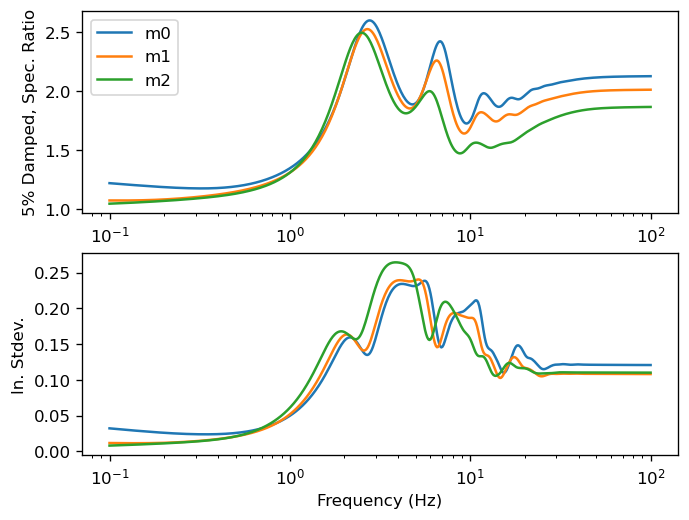

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;